In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import astropy.coordinates as coord
import astropy.constants as const


cantat = pd.read_csv('Data\\CantatGaudin\\cantatgaudinfile.csv')
cantat = cantat.assign(r50_dist = (np.tan(cantat['r50']*np.pi/180) * cantat['dmode']))
cantat = cantat.assign(inner = np.where(cantat['Plx'] > 1.1, 1, 0))

hunt = pd.read_csv('Data\\Hunt\\huntfile.csv').query('Type == "o"')
xmatch = pd.read_csv('Data\\Hunt\\xmatchfile.csv').dropna(subset=['Sep'])
khar = pd.read_csv('Data\\Kharchenko\\kharchenkofile.csv').query('Type != "g"')
dias = pd.read_csv('Data\\Dias\\diasfile.csv')
dias['Cluster'] = dias['Cluster'].str.replace(' ', '_').str.replace('-', '_')


## New datahandler
This new datahandler takes into account the different cluster groupings. Some clusters in the literature may all link to the one hunt cluster, i.e. 2 or more literature cluster are actually part of one ``supercluster" in Hunt&Reffert+23. Likewise, several Hunt clusters were previously misclassified into one supercluster, i.e. that cluster is actually a subcluster of a larger cluster in the literature. This datahandler creates an array with an added list of what the correspondences are


In [35]:
cantat_xm = xmatch.query('SourceCat == "Cantat-Gaudin+20"')
khar_xm = xmatch.query('SourceCat == "Kharchenko+13"')

def datahandler(df_lit, df=hunt, crossmatch=xmatch):

    if df_lit is cantat: # Define the source catalog and the column name of the cluster name, each table has different names for the cluster name column
        sourcecat = 'Cantat-Gaudin+20'
        NameCol = 'Cluster'
    elif df_lit is khar:
        sourcecat = 'Kharchenko+13'
        NameCol = 'Name'
    elif df_lit is dias:
        sourcecat = 'Dias+02'
        NameCol = 'Cluster'

    df = df.query('Type == "o"') #Only open clusters
    crossmatch = crossmatch.query('SourceCat == @sourcecat') #Crossmatch with the source catalog of the named catalogue
    crossmatch = crossmatch #Drop duplicates

    xm = pd.merge(crossmatch, df, on='ID', how='inner').drop_duplicates('ID') #Crossmatched clusters
    allnames = xm.assign(synonym = xm['AllNames'].str.split(',')).explode('synonym').add_suffix('_h') #Create AllNames column with synonyms of the OCs
    
    df_matched = pd.merge(df_lit, allnames, left_on=NameCol, right_on='synonym_h', how='outer', indicator=True) #Crossmatched clusters (matched with literature)

    matched = df_matched.query('_merge == "both"') #Matched clusters
    not_matched = df_matched.query('_merge == "left_only"') #Not matched clusters
    
    hunt_matched = matched.filter(regex='_h$').drop(columns=['synonym_h']) # Matched clusters in Hunt (I)
    # remove _h from the column names
    
    lit_matched = matched[df_lit.columns] # Matched clusters in literature (II)
    lit_not_matched = not_matched[df_lit.columns] # Not matched clusters in literature (III)
    
    superclusters = matched.groupby(['ID_h', 'Name_h'])[NameCol].agg(list).reset_index()
    superclusters = superclusters[superclusters[NameCol].apply(len) > 1]
    subclusters = matched.groupby([NameCol])[['ID_h', 'Name_h']].agg(list).reset_index()
    subclusters = subclusters[subclusters['ID_h'].apply(len) > 1]
    
    return matched, hunt_matched, lit_matched, lit_not_matched, superclusters, subclusters

### Table getter
Since our datahandler now returns more and more arrays. The arrays you can now get your table with the following commands for the ``part" argument in the function.
- part == 'full':
    - You get the fully matched array containing both the parameters from Hunt and from the literature
- part == 'matched':
    - You get the matched clusters with the Hunt data only, and one with literature data only. You might want to use only the Hunt matched data for better precision, or use the literature data to keep plots consistent with not matched clusters.  So this operation returns two DataFrames!
- part == 'unmatched':
    - With this you get all unmatched rejected clusters. This is only in literature paramaters (obviously).
- part == 'groups':
    - You get the superclusters and the subclusters

In [36]:
def get_tables(cat, part):
    if part == 'full':
        return datahandler(cat)[0]
    elif part == 'matched':
        return datahandler(cat)[1:3]
    elif part == 'unmatched':
        return datahandler(cat)[3]
    elif part == 'groups':
        return datahandler(cat)[-2:]

In [37]:
cantat_fullmatch = get_tables(cantat, 'full')

# get all duplicates in ID_h and sort on ID_h. Also only display the columns ID_h, Name_h, Cluster
duplicates = cantat_fullmatch[cantat_fullmatch.duplicated('ID_h', keep=False)].sort_values('ID_h')[['ID_h', 'Name_h', 'Cluster']].sort_values('ID_h')

#print('As we can see, a multiple literature clusters correspond to one literature cluster')
duplicates

,ID_h,Name_h,Cluster
134,196.0,Berkeley_14,Berkeley_14
135,196.0,Berkeley_14,Berkeley_14A
1225,308.0,COIN-Gaia_19,Stock_8
232,308.0,COIN-Gaia_19,COIN-Gaia_19
707,325.0,COIN-Gaia_38,Melotte_20
253,325.0,COIN-Gaia_38,COIN-Gaia_38
312,1378.0,Czernik_29,Czernik_29
574,1378.0,Czernik_29,Haffner_10
319,1470.0,FSR_0111,Czernik_39
984,1470.0,FSR_0111,NGC_6755


In [38]:
cantat_super,  cantat_sub = get_tables(cantat, 'groups')

print('Now we see that that the literature clusters are grouped in a list')
cantat_super

Now we see that that the literature clusters are grouped in a list


,ID_h,Name_h,Cluster
133,196.0,Berkeley_14,"[Berkeley_14, Berkeley_14A]"
230,308.0,COIN-Gaia_19,"[COIN-Gaia_19, Stock_8]"
247,325.0,COIN-Gaia_38,"[COIN-Gaia_38, Melotte_20]"
303,1378.0,Czernik_29,"[Czernik_29, Haffner_10]"
355,1470.0,FSR_0111,"[Czernik_39, NGC_6755]"
399,1561.0,FSR_0686,"[FSR_0686, UBC_55]"
491,1750.0,Gulliver_2,"[Gulliver_2, NGC_2546]"
495,1754.0,Gulliver_7,"[Gulliver_7, Ruprecht_77]"
498,1757.0,Gulliver_11,"[Gulliver_11, NGC_1582]"
502,1761.0,Gulliver_15,"[Gulliver_15, NGC_6561]"


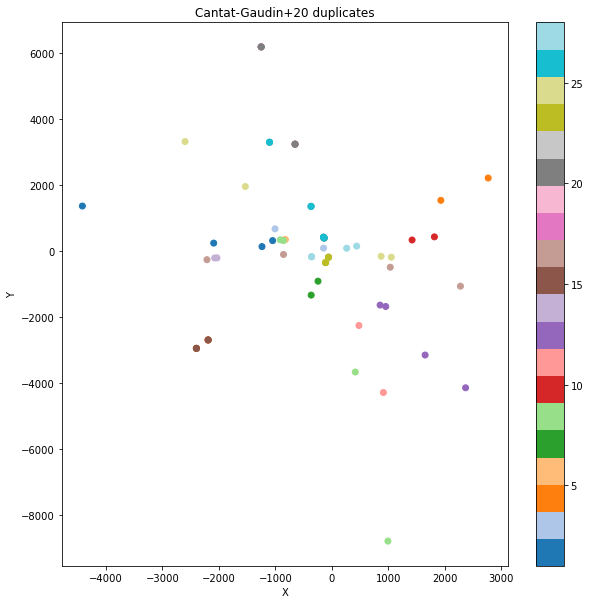

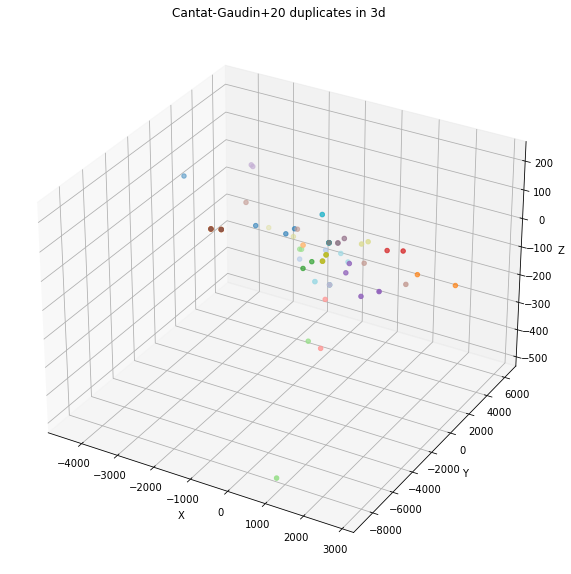

In [65]:

cantat_duplicates = cantat_fullmatch.query('ID_h in @duplicates.ID_h') # Get the duplicates from the full match

cantat_super['num'] = range(1, len(cantat_super) + 1) # Add a column with the number of the supercluster

cantat_superexp = cantat_super.explode('Cluster') # Explode the superclusters

cantat_mergecluster = pd.merge(cantat_superexp, cantat_duplicates, on='Cluster', how='inner') # Merge the superclusters with the duplicates
cantat_mergecluster


#//plot the x and y of cantat_mergecluster with the cluster names as labels and with the num column as color
plt.figure(figsize=(10, 10))
plt.scatter(cantat_mergecluster['X'], cantat_mergecluster['Y'], c=cantat_mergecluster['num'], cmap='tab20')
# for i, txt in enumerate(cantat_mergecluster['Cluster']):
#     plt.annotate(txt, (cantat_mergecluster['X'].iloc[i], cantat_mergecluster['Y'].iloc[i]))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Cantat-Gaudin+20 duplicates')
plt.colorbar()
plt.show()

#//3d plot the X and Y and Z columns of cantat_mergecluster with the cluster names as labels and with the num column as color
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cantat_mergecluster['X'], cantat_mergecluster['Y'], cantat_mergecluster['Z'], c=cantat_mergecluster['num'], cmap='tab20')
# for i, txt in enumerate(cantat_mergecluster['Cluster']):
#     ax.text(cantat_mergecluster['X'].iloc[i], cantat_mergecluster['Y'].iloc[i], cantat_mergecluster['Z'].iloc[i], txt)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
plt.title('Cantat-Gaudin+20 duplicates in 3d')
plt.show()















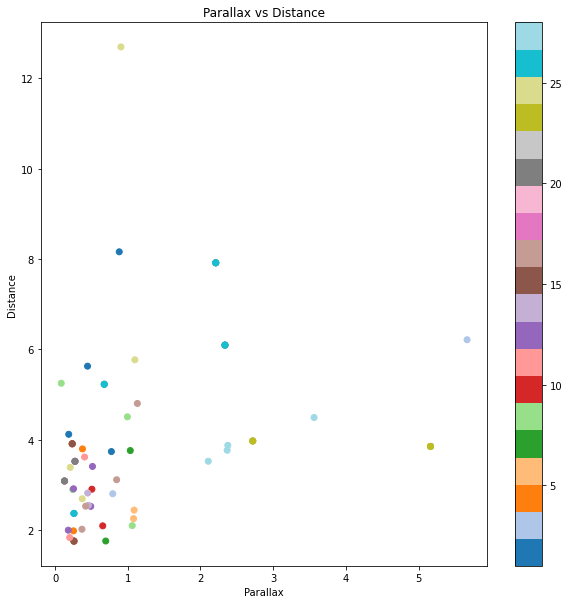

In [64]:
#ALSO LOOK AT MEMEBERS AND COLOR MAGNITUDE DIAGRAMS
#start looking into the clustering algorithms, and look at distance limits

#//plot the parallaxes of cantat_mergecluster with the cluster names as labels and with the num column as color
plt.figure(figsize=(10, 10))
plt.scatter(cantat_mergecluster['Plx'], cantat_mergecluster['r50_dist'], c=cantat_mergecluster['num'], cmap='tab20')


plt.xlabel('Parallax')
plt.ylabel('Distance')
plt.title('Parallax vs Distance')
plt.colorbar()
plt.show()